In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX

#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'

plt.style.use("seaborn-v0_8-dark")  

### VARMA
-----------------------------

In [3]:
# get the temperature data 

!wget -nc https://lazyprogrammer.me/course_files/timeseries/temperature.csv

--2024-04-11 22:59:23--  https://lazyprogrammer.me/course_files/timeseries/temperature.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4075992 (3.9M) [text/csv]
Saving to: 'temperature.csv'

temperature.csv     100%[===================>]   3.89M  4.64MB/s    in 0.8s    

2024-04-11 22:59:26 (4.64 MB/s) - 'temperature.csv' saved [4075992/4075992]



In [221]:
df = pd.read_csv('temperature.csv')

df.head()

,record_id,month,day,year,AverageTemperatureFahr,AverageTemperatureUncertaintyFahr,City,country_id,Country,Latitude,Longitude
0,474376,1,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
1,474377,2,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
2,474378,3,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
3,474379,4,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
4,474380,5,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E


In [222]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48470 entries, 0 to 48469
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   record_id                          48470 non-null  int64  
 1   month                              48470 non-null  int64  
 2   day                                48470 non-null  int64  
 3   year                               48470 non-null  int64  
 4   AverageTemperatureFahr             47541 non-null  float64
 5   AverageTemperatureUncertaintyFahr  47541 non-null  float64
 6   City                               47986 non-null  object 
 7   country_id                         47986 non-null  object 
 8   Country                            47986 non-null  object 
 9   Latitude                           48470 non-null  object 
 10  Longitude                          48470 non-null  object 
dtypes: float64(2), int64(4), object(5)
memory usage: 4.1+ 

In [223]:
# combine year month day columns into a date column with a datetime dtype 

df['Date'] = pd.to_datetime(df[['year', 'month', 'day']])

df.head()

,record_id,month,day,year,AverageTemperatureFahr,AverageTemperatureUncertaintyFahr,City,country_id,Country,Latitude,Longitude,Date
0,474376,1,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E,1853-01-01
1,474377,2,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E,1853-02-01
2,474378,3,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E,1853-03-01
3,474379,4,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E,1853-04-01
4,474380,5,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E,1853-05-01


In [224]:
df['Date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 48470 entries, 0 to 48469
Series name: Date
Non-Null Count  Dtype         
--------------  -----         
48470 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 378.8 KB


In [225]:
# there are missing columns 
df.isna().sum()

record_id                              0
month                                  0
day                                    0
year                                   0
AverageTemperatureFahr               929
AverageTemperatureUncertaintyFahr    929
City                                 484
country_id                           484
Country                              484
Latitude                               0
Longitude                              0
Date                                   0
dtype: int64

In [226]:
# focus on the cities auckland and stockholm 

df_auckland = df[df.City == 'Auckland'].copy().dropna()
df_stockholm = df[df.City == 'Stockholm'].copy().dropna()

df_auckland.shape, df_stockholm.shape

((1906, 12), (3136, 12))

In [227]:
df_auckland.head()

,record_id,month,day,year,AverageTemperatureFahr,AverageTemperatureUncertaintyFahr,City,country_id,Country,Latitude,Longitude,Date
5,474381,6,1,1853,51.9062,36.9572,Auckland,NEW,New Zealand,36.17S,175.03E,1853-06-01
6,474382,7,1,1853,52.3886,34.5488,Auckland,NEW,New Zealand,36.17S,175.03E,1853-07-01
7,474383,8,1,1853,52.8530,33.5498,Auckland,NEW,New Zealand,36.17S,175.03E,1853-08-01
8,474384,9,1,1853,52.5776,33.6380,Auckland,NEW,New Zealand,36.17S,175.03E,1853-09-01
9,474385,10,1,1853,54.8726,33.9836,Auckland,NEW,New Zealand,36.17S,175.03E,1853-10-01


In [228]:
# keep only the columns we want, which is Date and Average Temperature in Fahrenheit 

df_auckland = df_auckland[['Date', 'AverageTemperatureFahr']].copy()
df_stockholm = df_stockholm[['Date', 'AverageTemperatureFahr']].copy()

df_stockholm.head()

,Date,AverageTemperatureFahr
31416,1743-11-01,42.8414
31421,1744-04-01,36.8888
31422,1744-05-01,45.1220
31423,1744-06-01,53.1824
31424,1744-07-01,60.0260


In [229]:
# set index to Date and rename the temperature column 

df_auckland.set_index('Date', inplace = True)
df_stockholm.set_index('Date', inplace = True)

df_auckland.columns = ['AucklandTemp'] 
df_stockholm.columns = ['StockholmTemp']

df_auckland.head()



,AucklandTemp
Date,
1853-06-01,51.9062
1853-07-01,52.3886
1853-08-01,52.8530
1853-09-01,52.5776
1853-10-01,54.8726


In [230]:
df_stockholm.head()

,StockholmTemp
Date,
1743-11-01,42.8414
1744-04-01,36.8888
1744-05-01,45.1220
1744-06-01,53.1824
1744-07-01,60.0260


In [231]:
# we need to join the tables with outer join so that we have all the rows of both datasets where overlapping Dates are also possible. When dates are non-overlapping
# it will return NaN values  

j_temp = df_auckland.join(df_stockholm, how = 'outer')

j_temp.shape

(3155, 2)

In [232]:
# joined data has more rows than the stockholm data which has more rows as compared to auckland. This means that there are 19 NaN values in the joined data 
# corresponding to stockholm temp originating from the non-overlapping auckland Dates 

j_temp.isna().sum()['StockholmTemp'] + len(df_stockholm) == len(j_temp)

True

In [233]:
# 3155 data is too much apperently for VARMA to handle 

j_temp_part = j_temp[-500:].copy()
j_temp_part.index.freq = 'MS'


In [234]:
j_temp_part.isna().sum()

AucklandTemp     1
StockholmTemp    4
dtype: int64

In [235]:
# interpolate the missing values 

j_temp_part.interpolate(inplace = True)

j_temp_part.isna().sum()

AucklandTemp     0
StockholmTemp    0
dtype: int64

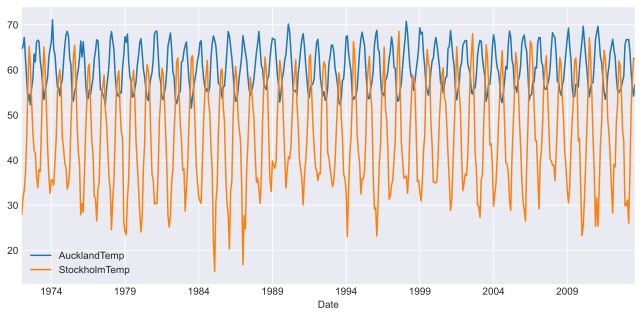

In [236]:
# plot the data together 

fig, axes = plt.subplots(figsize = (11,5))

j_temp_part.plot(ax = axes)

axes.grid()

Temperatures are not on the same scale, which prompt us to scale the data

In [237]:
# first train-test split 

Ntest = 12
train, test = j_temp_part[:-Ntest].copy(), j_temp_part[-Ntest:].copy()



In [238]:
# Scale temperature data for both cities seperately, note that we should scale and transform for the train sets and only transform the tests 

scaler_auckland = StandardScaler()

train['AucklandTemp_Scaled'] = scaler_auckland.fit_transform(train[['AucklandTemp']])
test['AucklandTemp_Scaled'] = scaler_auckland.transform(test[['AucklandTemp']])

In [239]:
scaler_stockholm = StandardScaler()

train['StockholmTemp_Scaled'] = scaler_stockholm.fit_transform(train[['StockholmTemp']])
test['StockholmTemp_Scaled'] = scaler_stockholm.transform(test[['StockholmTemp']])

In [240]:
train_idx = j_temp_part.index <= train.index[-1]
test_idx = j_temp_part.index > train.index[-1]

In [241]:
# put the scaled data into the original joined df 

j_temp_part.loc[train_idx, 'AucklandTemp_Scaled'] = train['AucklandTemp_Scaled']
j_temp_part.loc[test_idx, 'AucklandTemp_Scaled'] = test['AucklandTemp_Scaled']

j_temp_part.loc[train_idx, 'StockholmTemp_Scaled'] = train['StockholmTemp_Scaled']
j_temp_part.loc[test_idx, 'StockholmTemp_Scaled'] = test['StockholmTemp_Scaled']


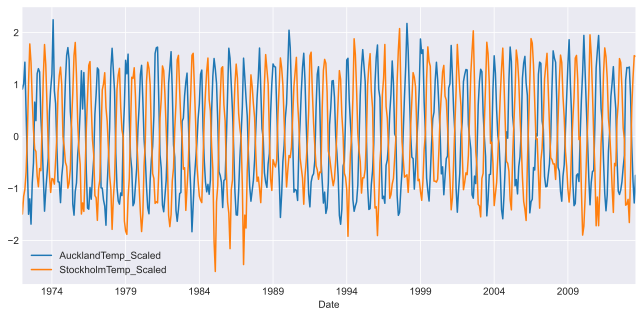

In [242]:
cols = ['AucklandTemp_Scaled', 'StockholmTemp_Scaled']

fig, axes = plt.subplots(figsize = (11,5))

j_temp_part[cols].plot(ax = axes)

axes.grid()

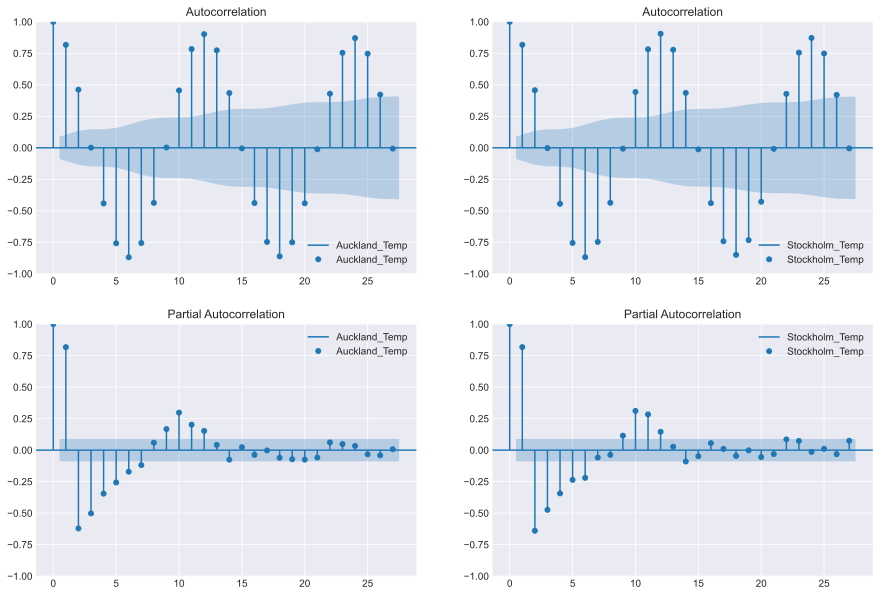

In [243]:
# Plot acf and pacf for both series 

fig, axes = plt.subplots(2,2, figsize = (15,10))

plot_acf(train['AucklandTemp_Scaled'], ax = axes[0,0],  label = 'Auckland_Temp');
plot_acf(train['StockholmTemp_Scaled'], ax = axes[0,1], label = 'Stockholm_Temp');

plot_pacf(train['AucklandTemp_Scaled'], ax = axes[1,0], label = 'Auckland_Temp');
plot_pacf(train['StockholmTemp_Scaled'], ax = axes[1,1], label = 'Stockholm_Temp');

for i in range(0,2):
    for j in range(0,2):
        axes[i,j].grid()
        axes[i,j].legend()


Notice that acf has a strong seasonal pattern, pacf's has a similar patter with the exception that lags closer to the 0 are more pronounced

In [244]:
# train and fit 

t0 = datetime.now()

model = VARMAX(train[cols], order = (10,10))

res = model.fit(maxiter = 100)

print(f"Duration of training {datetime.now()-t0}")

/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           85     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.88166D-01    |proj g|=  4.98695D-01


 This problem is unconstrained.



At iterate    5    f=  2.74661D-01    |proj g|=  1.76113D-01

At iterate   10    f=  2.57041D-01    |proj g|=  1.21188D-01

At iterate   15    f=  2.43906D-01    |proj g|=  1.86507D-01

At iterate   20    f=  2.28385D-01    |proj g|=  1.44935D-01

At iterate   25    f=  2.16511D-01    |proj g|=  4.70645D-02

At iterate   30    f=  2.12106D-01    |proj g|=  7.70691D-02

At iterate   35    f=  2.06769D-01    |proj g|=  1.98770D-01

At iterate   40    f=  2.05101D-01    |proj g|=  2.67865D-01

At iterate   45    f=  2.03226D-01    |proj g|=  1.49043D-01

At iterate   50    f=  2.01827D-01    |proj g|=  6.08951D-02

At iterate   55    f=  1.99244D-01    |proj g|=  6.27011D-02

At iterate   60    f=  1.96650D-01    |proj g|=  1.44245D-01

At iterate   65    f=  1.93277D-01    |proj g|=  8.10506D-02

At iterate   70    f=  1.90846D-01    |proj g|=  2.74617D-01

At iterate   75    f=  1.88338D-01    |proj g|=  2.02556D-01

At iterate   80    f=  1.83130D-01    |proj g|=  5.65137D-01

At iter

/opt/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate  100    f=  1.75674D-01    |proj g|=  1.97679D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   85    100    114      1     0     0   1.977D-01   1.757D-01
  F =  0.17567407031449850     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Duration of training 0:01:04.142888


In [245]:
# get fitted values and forecast 

train_pred = res.fittedvalues 
fcast = res.get_forecast(Ntest)


In [247]:
train_pred.head()

,AucklandTemp_Scaled,StockholmTemp_Scaled
Date,,
1972-01-01,-0.006979,-0.005571
1972-02-01,0.823210,-1.096085
1972-03-01,0.714509,-0.739977
1972-04-01,0.811502,-0.609896
1972-05-01,-0.086344,0.008490


In [248]:
fcast.predicted_mean.head()

,AucklandTemp_Scaled,StockholmTemp_Scaled
2012-09-01,-0.911306,0.875644
2012-10-01,-0.565275,0.368567
2012-11-01,0.119357,-0.311438
2012-12-01,0.773376,-0.809810
2013-01-01,1.388084,-1.228447


In [249]:
# insert train and test predictions to the original data frame 

test_pred = fcast.predicted_mean

j_temp_part.loc[train_idx, 'Fitted_Auckland'] = train_pred['AucklandTemp_Scaled']
j_temp_part.loc[train_idx, 'Fitted_Stockholm'] = train_pred['StockholmTemp_Scaled']

j_temp_part.loc[test_idx, 'Testp_Auckland'] = test_pred['AucklandTemp_Scaled']
j_temp_part.loc[test_idx, 'Testp_Stockholm'] = test_pred['StockholmTemp_Scaled']

In [250]:
j_temp_part

,AucklandTemp,StockholmTemp,AucklandTemp_Scaled,StockholmTemp_Scaled,Fitted_Auckland,Fitted_Stockholm,Testp_Auckland,Testp_Stockholm
Date,,,,,,,,
1972-01-01,64.7312,27.9194,0.912482,-1.491603,-0.006979,-0.005571,NaN,NaN
1972-02-01,65.2010,31.8020,1.010449,-1.150745,0.823210,-1.096085,NaN,NaN
1972-03-01,67.2116,33.3140,1.429716,-1.018004,0.714509,-0.739977,NaN,NaN
1972-04-01,62.6378,37.1462,0.475948,-0.681570,0.811502,-0.609896,NaN,NaN
1972-05-01,58.4708,44.9906,-0.392990,0.007099,-0.086344,0.008490,NaN,NaN
...,...,...,...,...,...,...,...,...
2013-04-01,64.1102,36.8096,0.782986,-0.711121,NaN,NaN,0.377977,-0.441743
2013-05-01,59.5004,51.3428,-0.178289,0.564767,NaN,NaN,-0.285718,0.270038
2013-06-01,56.2100,57.7544,-0.864432,1.127649,NaN,NaN,-0.873600,1.037025


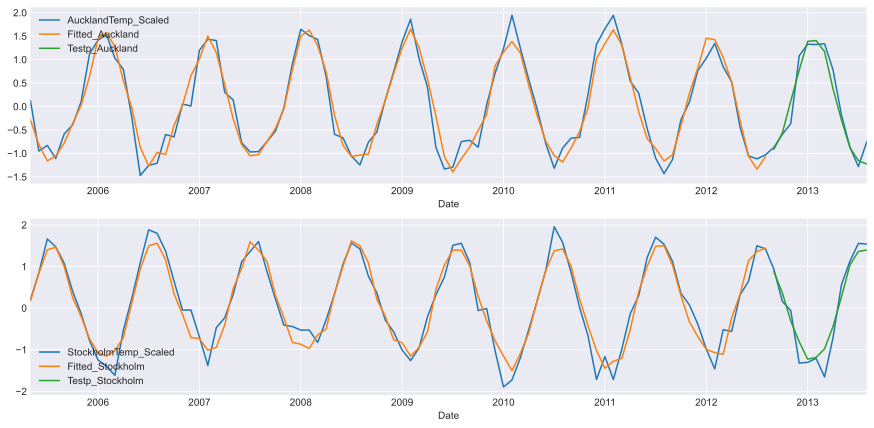

In [252]:
fig, axes = plt.subplots(2,1,figsize = (15,7))

auck_cols = [j_temp_part.columns.to_list()[2],j_temp_part.columns.to_list()[4], j_temp_part.columns.to_list()[6]]
stock_cols = [j_temp_part.columns.to_list()[3],j_temp_part.columns.to_list()[5], j_temp_part.columns.to_list()[7]]

j_temp_part[-100:][auck_cols].plot(ax = axes[0])

j_temp_part[-100:][stock_cols].plot(ax = axes[1])

for i in range(2):
    axes[i].grid()



Both train and test predictions look pretty good. 

In [253]:
# R^2 scores 

y_fitted, y_true = j_temp_part.loc[train_idx, 'Fitted_Stockholm'], j_temp_part.loc[train_idx, 'StockholmTemp_Scaled']
y_pred, y_test = j_temp_part.loc[test_idx, 'Testp_Stockholm'], j_temp_part.loc[test_idx, 'StockholmTemp_Scaled']

print(f"Train R^2 for Stockholm: {r2_score(y_fitted,y_true)}")
print(f"Test R^2 for Stockholm: {r2_score(y_pred,y_test)}")

Train R^2 for Stockholm: 0.9177918957257627
Test R^2 for Stockholm: 0.9006051441629941


In [254]:
y_fitted, y_true = j_temp_part.loc[train_idx, 'Fitted_Auckland'], j_temp_part.loc[train_idx, 'AucklandTemp_Scaled']
y_pred, y_test = j_temp_part.loc[test_idx, 'Testp_Auckland'], j_temp_part.loc[test_idx, 'AucklandTemp_Scaled']

print(f"Train R^2 for Auckland: {r2_score(y_fitted,y_true)}")
print(f"Test R^2 for Auckland: {r2_score(y_pred,y_test)}")

Train R^2 for Auckland: 0.9234828567019993
Test R^2 for Auckland: 0.9270541327475663


### VAR(p) models 
---------------------

In [259]:
var_model = VAR(train[cols])

In [260]:
lag_order_res = var_model.select_order(maxlags = 15)
lag_order_res

In [261]:
lag_order_res.selected_orders

{'aic': 12, 'bic': 6, 'hqic': 11, 'fpe': 12}

In [262]:
var_results = var_model.fit(maxlags = 15, ic = 'aic')

In [264]:
lag_order = var_results.k_ar

In [265]:
lag_order

12

In [266]:
prior = train.iloc[-lag_order:][cols].to_numpy() # to forecast we need to pass the prior values of the chosen lag by the model 

fcast = var_results.forecast(prior, Ntest)

In [267]:
fcast # steps * 2 numpy array where columns correpond to Auckland and Stockholm

array([[-0.86491205,  0.9126215 ],
       [-0.46098815,  0.41187248],
       [ 0.06315052, -0.18716887],
       [ 0.67626557, -0.76482676],
       [ 1.14208172, -1.07130218],
       [ 1.22700523, -1.0937979 ],
       [ 0.9794002 , -0.80403685],
       [ 0.41338843, -0.40868501],
       [-0.20952007,  0.21598454],
       [-0.78821337,  0.85620681],
       [-1.10693186,  1.24994289],
       [-1.13507881,  1.24097996]])

In [269]:
var_results.fittedvalues

,AucklandTemp_Scaled,StockholmTemp_Scaled
Date,,
1973-01-01,1.131929,-0.862152
1973-02-01,1.378058,-1.013430
1973-03-01,1.065625,-0.890386
1973-04-01,0.476984,-0.411676
1973-05-01,-0.394570,0.224029
...,...,...
2012-04-01,0.581007,-0.153746
2012-05-01,-0.096826,0.258002
2012-06-01,-0.862746,1.031408


In [270]:
j_temp_part.loc[train_idx, 'Trainp_Auck_Var'] = var_results.fittedvalues['AucklandTemp_Scaled']
j_temp_part.loc[test_idx, 'Testp_Auck_Var'] = fcast[:,0] # 0 for Auckland 

j_temp_part.loc[train_idx, 'Trainp_Stock_Var'] = var_results.fittedvalues['StockholmTemp_Scaled']
j_temp_part.loc[test_idx, 'Testp_Stock_Var'] = fcast[:,1] # 0 for Auckland 


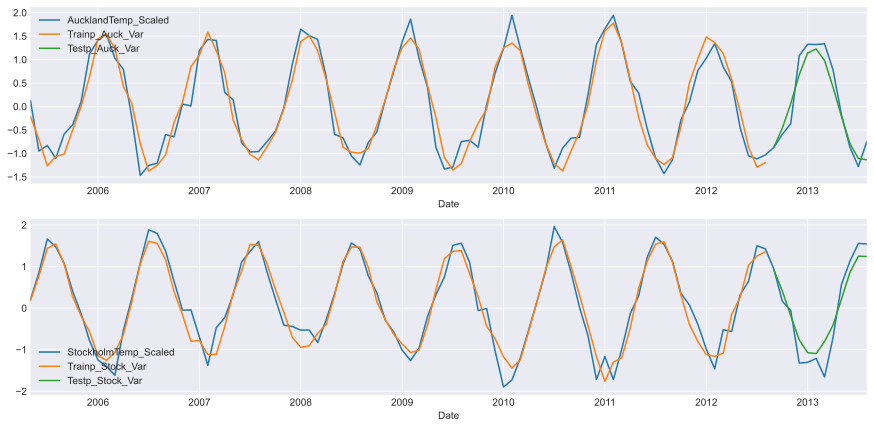

In [271]:
fig, axes = plt.subplots(2,1,figsize = (15,7))

auck_cols = ['AucklandTemp_Scaled',  'Trainp_Auck_Var', 'Testp_Auck_Var']
stock_cols = ['StockholmTemp_Scaled',  'Trainp_Stock_Var', 'Testp_Stock_Var']

j_temp_part[-100:][auck_cols].plot(ax = axes[0])

j_temp_part[-100:][stock_cols].plot(ax = axes[1])

for i in range(2):
    axes[i].grid()

Forecasts look pretty decent! 

In [272]:
# R^2 scores 

y_fitted, y_true = j_temp_part.loc[train_idx, 'Trainp_Stock_Var'], j_temp_part.loc[train_idx, 'StockholmTemp_Scaled']

y_fitted = y_fitted.iloc[lag_order:]
y_true = y_true.iloc[lag_order:]

y_pred, y_test = j_temp_part.loc[test_idx, 'Testp_Stock_Var'], j_temp_part.loc[test_idx, 'StockholmTemp_Scaled']

print(f"Train R^2 for Stockholm: {r2_score(y_fitted,y_true)}")
print(f"Test R^2 for Stockholm: {r2_score(y_pred,y_test)}")

Train R^2 for Stockholm: 0.9209056836304631
Test R^2 for Stockholm: 0.8088054949108381


In [273]:
y_fitted, y_true = j_temp_part.loc[train_idx, 'Trainp_Auck_Var'], j_temp_part.loc[train_idx, 'AucklandTemp_Scaled']

y_fitted = y_fitted.iloc[lag_order:]
y_true = y_true.iloc[lag_order:]

y_pred, y_test = j_temp_part.loc[test_idx, 'Testp_Auck_Var'], j_temp_part.loc[test_idx, 'AucklandTemp_Scaled']

print(f"Train R^2 for Auckland: {r2_score(y_fitted,y_true)}")
print(f"Test R^2 for Auckland: {r2_score(y_pred,y_test)}")

Train R^2 for Auckland: 0.914307012605129
Test R^2 for Auckland: 0.8992364356264174


Results are not as good as VARMA!

### Baseline with ARIMA 

In [275]:
from statsmodels.tsa.arima.model import ARIMA

for col in cols: 

    arima = ARIMA(train[col], order = (10,0,10))
    res = arima.fit()
    fcast = res.get_forecast(Ntest)
    
    print(f"{col} Train R^2, {r2_score(j_temp_part.loc[train_idx,col], res.fittedvalues):.3f}")
    print(f"{col} Test R^2, {r2_score(j_temp_part.loc[test_idx,col], fcast.predicted_mean):.3f}")

/opt/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AucklandTemp_Scaled Train R^2, 0.921
AucklandTemp_Scaled Test R^2, 0.938
StockholmTemp_Scaled Train R^2, 0.921
StockholmTemp_Scaled Test R^2, 0.948


/opt/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Baseline ARIMA for each data city temperature data performs better which has the assumption that there is no correlation between two cities. This is indeed expected as two cities are far apart. Since test $R^2$'s are larger than the training, these models overfit less as compared to VAR and VARMA.